In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Linear, ModuleList, ReLU
import torch.nn.functional as F
from torch.utils.data import Dataset

/home/dazhou/anaconda3/envs/calibration/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super().__init__()
        self.layers = ModuleList()
        input_fc = nn.Linear(input_dim, hidden_dim, bias=False)
        output_fc = nn.Linear(hidden_dim, output_dim, bias=False)
        self.layers.append(input_fc)
        if num_layers > 2:
            fc = nn.Linear(hidden_dim, hidden_dim, bias=False)
            self.layers.append(fc)
        self.layers.append(output_fc)
        self.num_layers = num_layers

    def forward(self, x):
        for i in range(self.num_layers-1):
            layer = self.layers[i]
            x = layer(x)
            x = F.relu(x)
        layer = self.layers[-1]
        x = layer(x)
        return x

In [3]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super().__init__()
        self.layers = ModuleList()
        rnn = torch.nn.GRU(input_dim,hidden_dim,num_layers)
        output_fc = nn.Linear(hidden_dim, output_dim, bias=False)
        self.layers.append(rnn)
        self.layers.append(output_fc)
        self.num_modules = 2

    def forward(self, x):
        for i in range(self.num_modules-1):
            layer = self.layers[i]
            x = layer(x)
            if type(x) is tuple:
                x=x[0][-1]
            x = F.relu(x)
        layer = self.layers[-1]
        x = layer(x)
        return x    

In [4]:
def generate_synthetic(
    N = 1000, # number of sequences
    M = 50, # length of each sequence
    p = 0.01, # probability of generating an anomaly
):
    start_range = [-1,1]
    all_sequences = [] # record all sequences
    y_list = [] # record the target
    moving_prob = {
        0: [0.9, 0.1], # normal
        1: [0.1, 0.9], # abnormal
    }
    steps = [(1.0,0.1),(0.1,1.0)]
    for i in range(N):
        if np.random.random() < p:
            # anomaly
            flag = 1
        else:
            # normal
            flag = 0
        y_list.append(flag)
        sequence = [np.random.random(2) * 10 + 10.]
        up_prob = moving_prob[flag][0]
        prev_point = sequence[-1]
        for j in range(M//2):
            step_length1 = 1. + np.random.random() / 10
            step_length2 = np.random.random() / 10
            if np.random.random() < up_prob:
                # mainly move up
                move = np.array([step_length1, step_length2])
            else:
                # mainly move down
                move = np.array([step_length2, step_length1])
            next_point = prev_point + move
            sequence.append(next_point)
            prev_point = next_point
        up_prob = moving_prob[flag][1]
        for j in range(M//2):
            step_length1 = 1. + np.random.random() / 10
            step_length2 = np.random.random() / 10
            if np.random.random() < up_prob:
                # mainly move up
                move = np.array([step_length1, step_length2])
            else:
                # mainly move down
                move = np.array([step_length2, step_length1])
            next_point = prev_point + move
            sequence.append(next_point)
            prev_point = next_point
            
        all_sequences.append(np.concatenate(sequence).reshape(-1,2))
    return all_sequences, y_list

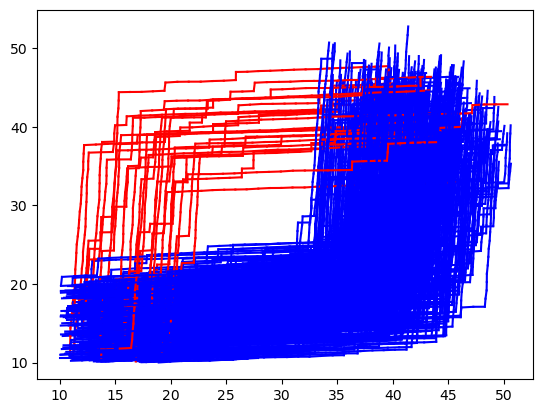

In [5]:
N = 500 # number of sequences
M = 50 # length of each sequence
p = 0.05 # probability of generating an anomaly
all_sequences, y_list = generate_synthetic(N, M, p)
for i in range(N):
    sequence = all_sequences[i]
    flag = y_list[i]
    color = 'blue' if flag == 0 else 'red'
    for j in range(len(sequence)-1):
        prev, now = sequence[j], sequence[j+1]
        concat_coor = np.concatenate([prev, now]).reshape(2,2).T
        plt.plot(concat_coor[0], concat_coor[1], color=color)

In [6]:
class synDataset(Dataset):
    def __init__(self, data):
        # with open(os.path.join(data_dir,file+"_ri.npy"), 'rb') as f:
        #     data = np.load(f)
        self.dataS=data[0]
        self.dataT=data[1] 
    def __len__(self) -> int:   #可以sample的数量
        return self.dataS.shape[0]
    def __getitem__(self, index):   #iNdex global
        return self.dataS[index],self.dataT[index]

In [7]:
class OneClassModel(nn.Module):
    def __init__(self, input_dim,input_dim_SRNN,input_dim_TRNN, hidden_dim, output_dim, num_layers=2, r=.1):
        super().__init__()
        self.encoder = MLP(input_dim, hidden_dim, output_dim, num_layers)
        self.Sencoder = RNN(input_dim_SRNN, hidden_dim, int(output_dim/2), num_layers)
        self.Tencoder = RNN(input_dim_TRNN, hidden_dim, int(output_dim/2), num_layers)
        self.center = torch.ones(output_dim, dtype=torch.float)
        self.r = torch.nn.Parameter(data=torch.tensor(r,dtype=torch.float), requires_grad=True)
    def forward(self, x):
        return self.encoder(x)
    def forward_RNN(self,x_s,x_t):
        embeds_s = self.Sencoder(x_s)
        embeds_t = self.Tencoder(x_t)
        embeds=torch.cat([embeds_s,embeds_t],1)
        return embeds
    
    def score(self, x):
        embeds = self.encoder(x)
        score = torch.cdist(embeds, self.center.view(1,-1))
        return score
    def score_RNN(self, x_s,x_t):
        embeds_s = self.Sencoder(x_s)
        embeds_t = self.Tencoder(x_t)
        embeds=torch.cat([embeds_s,embeds_t],1)
        score = torch.cdist(embeds, self.center.view(1,-1))
        return score    
    def oneclassLoss(self, x):
        embeds = self.encoder(x)
        distances = torch.cdist(embeds, self.center.view(1,-1))
        return torch.mean(torch.maximum(distances - self.r, torch.tensor([0.])))
    def oneclassLoss_RNN(self, x_s,x_t):
        embeds_s = self.Sencoder(x_s)
        embeds_t = self.Tencoder(x_t)
        embeds=torch.cat([embeds_s,embeds_t],1)
        distances = torch.cdist(embeds, self.center.view(1,-1))
        return torch.mean(torch.maximum(distances - self.r, torch.tensor([0.])))
data = torch.tensor(np.array(all_sequences), dtype=torch.float)
data_T=torch.rand(data.shape)
model = OneClassModel(input_dim=51*2,input_dim_SRNN=2,input_dim_TRNN=2, hidden_dim=16, output_dim=4, num_layers=3)

In [8]:
data.shape

torch.Size([500, 51, 2])

In [8]:
ds=synDataset([data.permute(1,0,2),data_T.permute(1,0,2)])
dl=torch.utils.data.DataLoader(ds,batch_size=64, shuffle=True) 

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
model.train()
for epoch in range(500):
    loss = model.oneclassLoss(data.view(-1,51*2)) + model.r**2
    # loss = model.oneclassLoss_RNN(data.permute(1,0,2),data_T.permute(1,0,2)) + model.r**2
    print("Epoch:{:03d}, loss={:.4f}, r={:.4f}".format(epoch, float(loss), float(model.r)))
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    optimizer.zero_grad()  # Clear gradients.
for epoch in range(500):
    loss_total=0
    for i,(data_s,data_t) in enumerate(dl):
        # loss = model.oneclassLoss(data.view(-1,51*2)) + model.r**2
        loss = model.oneclassLoss_RNN(data_s,data_t) + model.r**2
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        loss_total+=loss.detach()
    print("Epoch:{:03d}, loss={:.4f}, r={:.4f}".format(epoch, float(loss_total), float(model.r)))

Epoch:000, loss=2.4384, r=0.1000
Epoch:001, loss=9.5633, r=0.1100
Epoch:002, loss=11.4356, r=0.1200
Epoch:003, loss=6.6032, r=0.1300
Epoch:004, loss=1.5438, r=0.1399
Epoch:005, loss=3.5666, r=0.1499
Epoch:006, loss=3.4966, r=0.1598
Epoch:007, loss=2.5061, r=0.1697
Epoch:008, loss=2.1202, r=0.1795
Epoch:009, loss=2.5067, r=0.1893
Epoch:010, loss=2.4555, r=0.1990
Epoch:011, loss=1.9973, r=0.2087
Epoch:012, loss=1.6079, r=0.2183
Epoch:013, loss=1.4567, r=0.2278
Epoch:014, loss=1.3014, r=0.2373
Epoch:015, loss=1.1260, r=0.2466
Epoch:016, loss=1.0262, r=0.2559
Epoch:017, loss=0.8842, r=0.2651
Epoch:018, loss=0.6492, r=0.2742
Epoch:019, loss=0.3635, r=0.2831
Epoch:020, loss=0.1256, r=0.2920
Epoch:021, loss=0.1447, r=0.2998
Epoch:022, loss=0.3004, r=0.3069
Epoch:023, loss=0.3514, r=0.3140
Epoch:024, loss=0.3004, r=0.3211
Epoch:025, loss=0.2295, r=0.3283
Epoch:026, loss=0.1908, r=0.3354
Epoch:027, loss=0.1529, r=0.3415
Epoch:028, loss=0.1349, r=0.3465
Epoch:029, loss=0.1617, r=0.3499
Epoch:030

In [10]:
embeds = model(data.view(-1,51*2))
distances = torch.cdist(embeds, model.center.view(1,-1))
scores = distances#torch.maximum(distances - .1, torch.tensor([0.]))

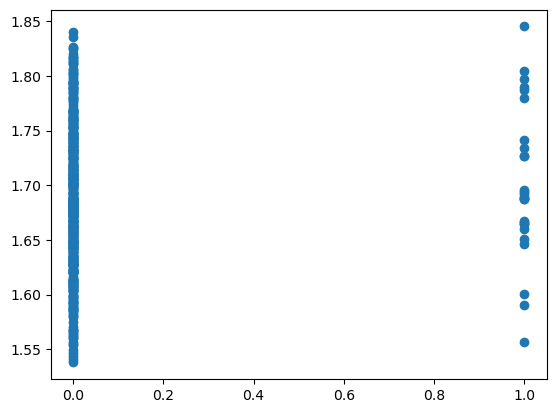

In [11]:
# plt.scatter(y_list, scores.view(-1).detach().numpy())
plt.scatter(y_list, model.score(data.view(-1,51*2)).view(-1).detach().numpy())

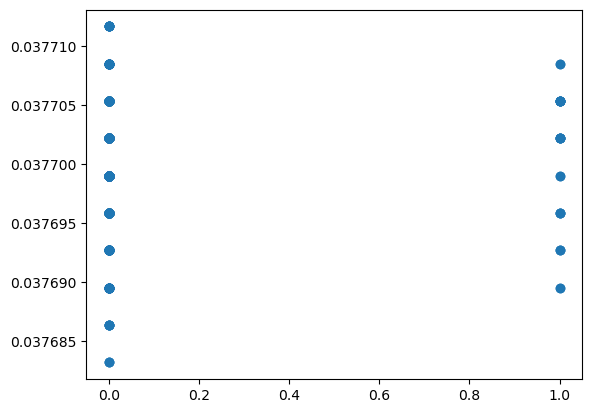

In [12]:
plt.scatter(y_list, model.score_RNN(data.permute(1,0,2),data_T.permute(1,0,2)).view(-1).detach().numpy())

In [13]:
sum(y_list)

27

In [14]:
len(y_list)

500